In [1]:
%matplotlib inline

In [2]:
#!pip install --upgrade albumentations
#!pip install torchsummary

In [3]:
import torch  
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt


from s8model import Net
from s8utils import create_train_test_sets, show, show_with_gradcam
from torchsummary import summary

# Helper scripts for train, test and pick 10 incorrect

In [26]:
from tqdm import tqdm
def train(m, device, train_loader, optimizer, loss_function, epoch):
    m.train()
    correct = 0
    running_loss = 0.0
    num_batches = 0
    for data, target in train_loader:
        num_batches += 1
        data, target = data.to(device), target.to(device)
        optimizer.zero_grad()
        output = m(data)
        loss = loss_function(output, target)
        
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
        deltac = pred.eq(target.view_as(pred)).sum().item()
        correct += deltac
    epoch_loss = running_loss/num_batches
    print(f'Epoch {epoch}, loss {epoch_loss:.4f} train accuracy {100*correct / len(train_loader.dataset)}')

    
def test(m, device, test_loader, loss_function, epoch):
    m.eval()
    test_loss = 0
    correct = 0
    num_batches = 0
    incorrect_images= []
    with torch.no_grad():
        for data, target in test_loader:
            num_batches += 1
            data, target = data.to(device), target.to(device)
            output = m(data)
            
            test_loss += loss_function(output, target).item()
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            #target = target.argmax(dim=0, keepdim=True)
            deltac = pred.eq(target.view_as(pred)).sum().item()
            correct += deltac
            
    test_loss /= num_batches
    test_acc = 100. * correct / len(test_loader.dataset)
    print(f'Test loss {test_loss:.3f}, test accuracy {100. * correct / len(test_loader.dataset)}\n')
    return test_loss, test_acc


def get_incorrect(m, device, test_loader):
    m.eval()
    incorrect_images= []
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = m(data)
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability

            pred_np = pred.cpu().numpy().squeeze()
            target_np = target.cpu().numpy().squeeze()
            for idx in range(len(pred_np)):
                if (pred_np[idx] != target_np[idx]):
                    incorrect_images.append((data[idx].cpu().numpy(), target_np[idx]))
                    if (len(incorrect_images)>=10):
                        return incorrect_images
    return incorrect_images

# Main routine

In [5]:
## run on GPU
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

MEAN = 0.5
STD = 0.25
train_dataloader, test_dataloader = create_train_test_sets(MEAN, STD)

net = Net().to(device)
criterion = nn.CrossEntropyLoss()
#optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)
optimizer = optim.Adam(net.parameters(), lr=0.01)
for epoch in range(20):
    train(net, device, train_dataloader, optimizer, criterion, epoch)
    test(net, device, test_dataloader, criterion, epoch)
    

/media/App/anaconda3/envs/NN/lib/python3.9/site-packages/albumentations/augmentations/transforms.py:689: FutureWarning: This class has been deprecated. Please use CoarseDropout
  warnings.warn(


Files already downloaded and verified
Files already downloaded and verified
Epoch 0, loss 1.5398 train accuracy 43.48
Test loss 1.926, test accuracy 32.76

Epoch 1, loss 1.2096 train accuracy 56.422
Test loss 1.472, test accuracy 46.71

Epoch 2, loss 1.0551 train accuracy 62.226
Test loss 1.521, test accuracy 49.04

Epoch 3, loss 0.9596 train accuracy 65.976
Test loss 1.696, test accuracy 42.68

Epoch 4, loss 0.8952 train accuracy 68.296
Test loss 1.253, test accuracy 56.94

Epoch 5, loss 0.8438 train accuracy 70.434
Test loss 1.135, test accuracy 60.63

Epoch 6, loss 0.7978 train accuracy 71.774
Test loss 1.494, test accuracy 51.51

Epoch 7, loss 0.7645 train accuracy 73.098
Test loss 1.353, test accuracy 54.87

Epoch 8, loss 0.7346 train accuracy 73.98
Test loss 1.281, test accuracy 57.27

Epoch 9, loss 0.7099 train accuracy 75.012
Test loss 1.336, test accuracy 54.23

Epoch 10, loss 0.6891 train accuracy 75.666
Test loss 1.267, test accuracy 58.61

Epoch 11, loss 0.6762 train accura

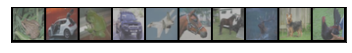

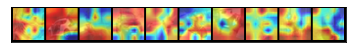

In [27]:
## view incorrect images, normalized back
incorrect_images = get_incorrect(net, device, test_dataloader)
show(incorrect_images, STD, MEAN)

## pass incorrect images and target label to gradcam
show_with_gradcam(incorrect_images, net, use_cuda, STD, MEAN)

In [22]:
#DEBUG
